# 13 Economic Mobility SHAP Analysis

**Project:** NORI  
**Author:** Yuseof J  
**Date:** 28/12/25

### **Purpose**


### **Inputs**
- ``

### **Outputs**
- ``
  
--------------------------------------------------------------------------

### 0. Imports and Setup

In [9]:
# package imports
import os
import shap
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# specify filepaths
path_model_features = 'data/processed/master_features.csv'
path_final_model_pkl = 'models/xgb_econ_mobility_model.pkl'

# ensure cwd is project root for file paths to function properly
project_root = Path(os.getcwd())            # get current directory
while not (project_root / "data").exists(): # keep moving up until in parent
    project_root = project_root.parent
os.chdir(project_root)                      # switch to parent directory

### 1. Load Data

In [2]:
# load economic mobility model
with open(path_final_model_pkl, 'rb') as model_file:
    model = pickle.load(model_file)

# load tracts with features 
X = pd.read_csv(path_model_features)

### 2. SHAP Analysis

In [3]:
# drop nan rows in feature set before running shap 
X = X.dropna()

# drop geoid
X.drop(columns=['GEOID'], inplace=True)

In [4]:
X.head()

,distance_to_park_m,park_area_500m_centroid,park_area_1km_centroid,percent_tree_canopy,median_household_income,poverty_rate,unemployment_rate,gini_index,pct_higher_ed,pct_renters,median_gross_rent,pct_rent_burdened,pct_no_vehicle,pop_density_sq_km,pct_age_65_plus
0,169.509962,1.206043e+05,6.859291e+05,0.031706,117981.0,0.029496,0.024523,0.4031,0.427270,0.181553,1429.0,0.324759,0.042032,2692.772684,0.193930
1,2129.879397,0.000000e+00,0.000000e+00,0.000000,96684.0,0.099770,0.030645,0.4349,0.311325,0.182136,1799.0,0.698630,0.005988,11465.037656,0.191336
2,0.000000,1.370448e+06,4.764153e+06,0.000000,61378.0,0.083870,0.037376,0.4349,0.259306,0.648697,1797.0,0.694598,0.004942,4022.827347,0.186134
3,622.327717,0.000000e+00,3.497273e+05,0.000000,67500.0,0.398833,0.069648,0.3851,0.313904,0.621649,1748.0,0.601990,0.106186,23808.910470,0.078171
4,972.144627,0.000000e+00,1.453035e+03,0.000000,51250.0,0.451197,0.177823,0.5221,0.188471,0.733522,1630.0,0.593068,0.104520,32376.888983,0.078985


In [5]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 94%|=================== | 2029/2168 [00:13<00:00]       

#### **A. Global Importance Plot**

Which features matter most overall to the model's predictions?

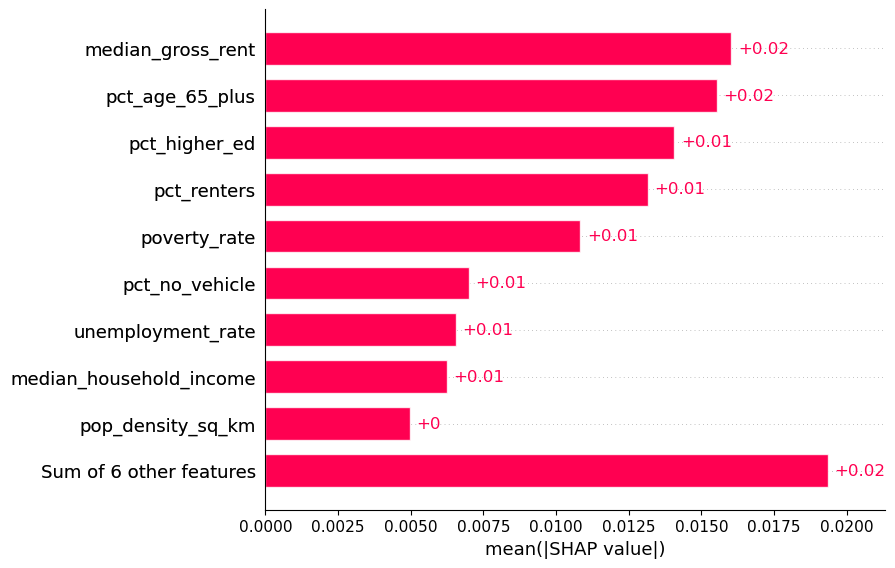

In [6]:
shap.plots.bar(shap_values)

Here we see that the top drivers of the model's economic mobility predictions are related to housing and demographics / socioeconomic features. None of current our park / green space features are heavily influencing the model's predictions. We should take this with a grain of salt, given the fact that our model's current feature set only explains 11% of the variation in tract-level economic mobility outcomes. So although these findings indicate the possibility that scoecioeconomic factors may better explain variation in mobility outcomes than the built environment does, it may also indiciate that these *specific* green features are not as influential as other green features might be. More analysis is needed to know for sure. 

#### **B. Beeswarm Plot**

How do high and low feature values impact model predictions across tracts?

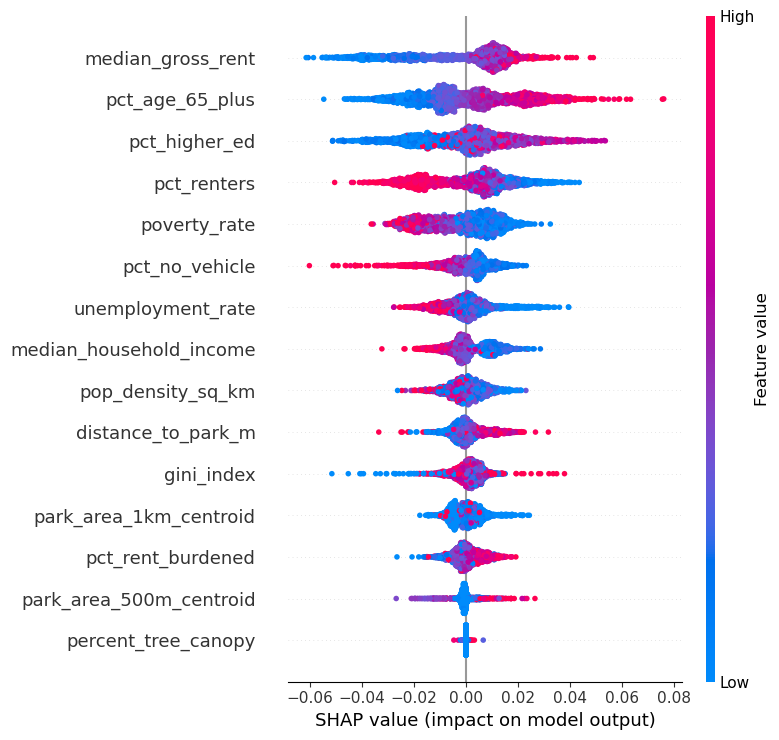

In [7]:
shap.summary_plot(shap_values, X)

This SHAP beeswarm plot gives us an idea of how specific values of the model's most influential features contribute to the model's predictions for long-run mobility outcomes. Importantly, these observed relationships are correlations learned by the model rather than causal effects. As such, these results should be interpreted as signals for further investigation, such as causal inference, in order to make any policy reccomendations based on the features observed in the plot.

The highest drivers of model predictions are median_gross_rent, pct_age_65_plus, and pct_higher_ed. In general, they suggest low feature values are somewhat aligned with lower model preictions, and vice versa. However, they do not display perfectly linear shapes (we see some clustering). Additionally, given the large spread of the prediction points, theres a possibility that the features behave differently depending on neighborhood context and relationships with other features. We will investigate this further in the dependence plots below. 

#### **C. Dependence Plots**

How do model predictions change with respect to individual features?

In this section, we take a closer look at 
1. High-influence features from beeswarm and global importance plots
2. Features that display clustering and non-linear shapes such as thresholds and plateaus (offer potential insights into feature interactions and context-dependent predictions)
3. Features that are particularly relevant to the policy question's being asked (e.g. How does the built environment impact health and long-run economic mobility? Which neighborhood characteristics are associated with favorable and unfavorable health and mobility outcomes?)

The code below creates dependence plots for each of the top features, along with plots for feature interaction. This is done in order to get a quick glance at all important features, allowing us to determine which are worth analyzing further. We are looking for features with some mix of the following: vertical spread, clear directionality, non-linearity/clustering/thresholds, coverage across the feature range, strong color seperation in feature interactions, or consistently positive or negative SHAP values. 

In [10]:
num_features_to_inspect = 15

# determine features with highest abs SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# sort features by SHAP value descending
top_features = [
    shap_values.feature_names[i]
    for i in np.argsort(mean_abs_shap)[::-1]
]

# select features for spot check
top_features = top_features[:num_features_to_inspect]

In [12]:
# for each feature: a dependence plot, and a feature interaction plot
'''
for feature in top_features:
    shap.plots.scatter(shap_values[:, feature])
    shap.dependence_plot(feature, shap_values.values, X)
'''

'\nfor feature in top_features:\n    shap.plots.scatter(shap_values[:, feature])\n    shap.dependence_plot(feature, shap_values.values, X)\n'

Above code adds alot of clutter to the notebook. After reviewing all top features, we simply select the top 3-5 for in-depth analysis and remove this code's output from the notebook.

---

*Median Gross Rent*

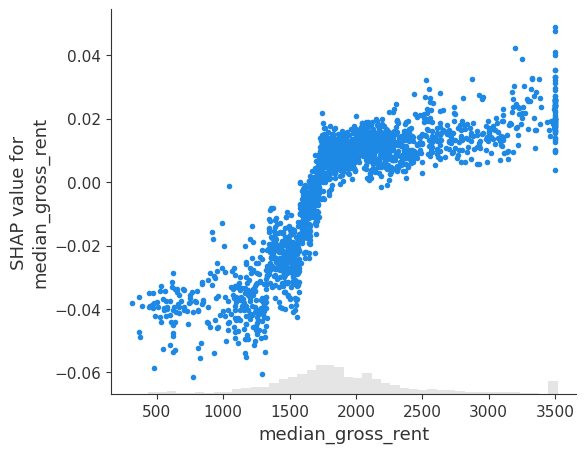

In [13]:
shap.plots.scatter(shap_values[:, "median_gross_rent"])

Here we observe an interesting threshold-like effect (SHAP values are negative up to a specific point). It appears that between the \\$1500 - \\$1800 median rent pricepoint specifically, SHAP values go from negative to positive. The general relationship makes sense (i.e. lower rent associated with lower predicted economic mobility, since we would expect higher income residents to live in more expensive neighborhoods). However, the relationship observed in model predictions relative to median rent isn't perfectly linear, with something about this specific price range changing predictions. 

*Median Gross Rent Interaction with Poverty Rate*

By incoporating the feature interacting most with median_gross_rent (i.e. poverty_rate), we can see that perhaps its not simply about some arbitrary price point. This price range seems to coincide with a change in poverty rate. This seems to make sense since poverty rate and median rent are both heavily correlated / proxies for income, which the economic mobility outcome variable is measuring (i.e. income rank).

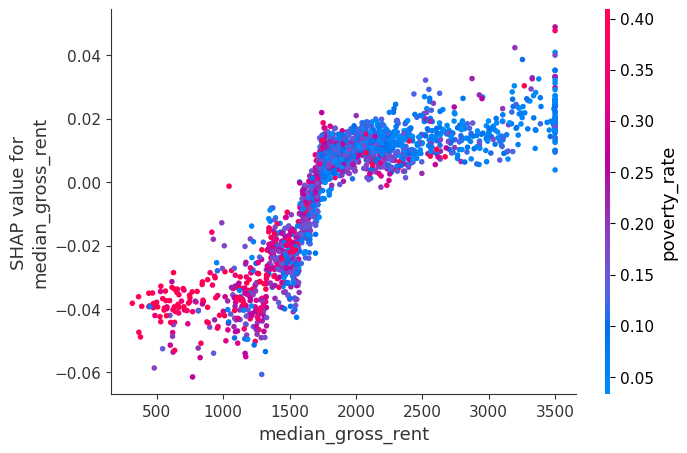

In [18]:
shap.dependence_plot("median_gross_rent",
                    shap_values.values,
                    X)

---

*% Age 65+*

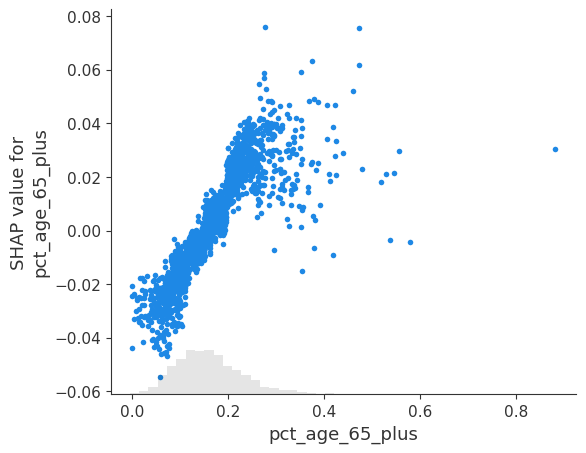

In [30]:
shap.plots.scatter(shap_values[:, "pct_age_65_plus"])

Here we see that contrary to the health model, tract rates of 65+ year olds show a strong *positive* linear association with predicted economic mobility

---

*Median Household Income*

In [ ]:
Why are we seeing higher household incomes associated with LOWER econ mobility predictions???

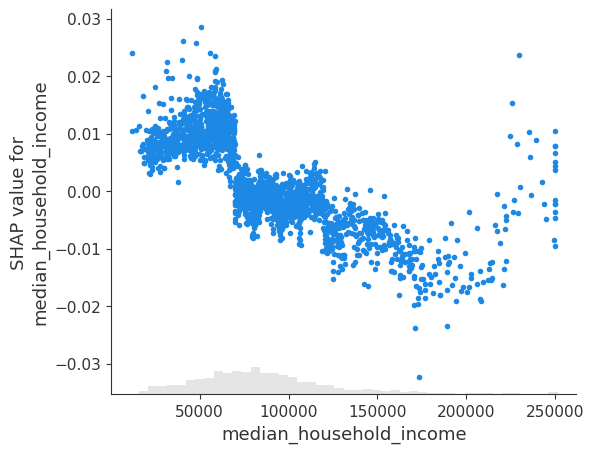

In [22]:
shap.plots.scatter(shap_values[:, "median_household_income"])

---

*% Higher Education*

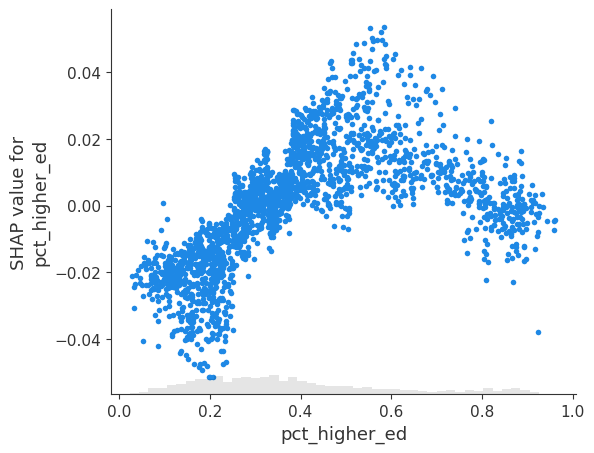

In [10]:
shap.plots.scatter(shap_values[:, "pct_higher_ed"])

Here we observe a positive linear relationship between pct_higher_ed and mobility predictions, but only up until about 60%, after which there is a weak/noisy decline in SHAP values, clustering around 0. 

Below, we see that this post 60% decline is not arbitrary, but rather it appears to be influenced by interactions with rent and household income. More specifically, we see that increased attaintment of higher education appears to have less impact on mobility predictions in both high median rent and high median income tracts. 

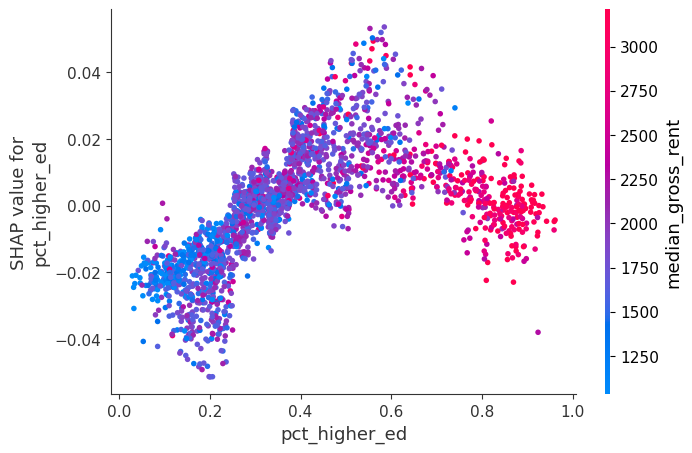

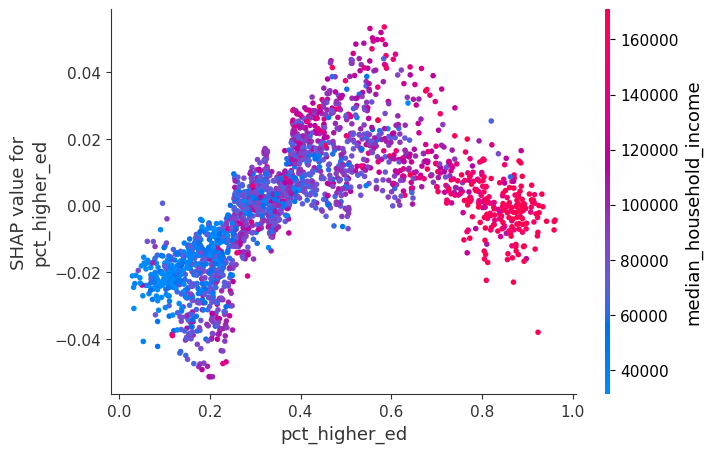

In [22]:
for feature in ['median_gross_rent', 'median_household_income']:
    shap.dependence_plot("pct_higher_ed",
                        shap_values.values,
                        X,
                        interaction_index=feature)

In [23]:
# a method for spot checking interactions between feature under observation and other features that are 
# influencing its predictive importance
'''
for feature in top_features:
    shap.dependence_plot("pct_higher_ed",
                    shap_values.values,
                    X,
                    interaction_index=feature)
'''

'\nfor feature in top_features:\n    shap.dependence_plot("pct_higher_ed",\n                    shap_values.values,\n                    X,\n                    interaction_index=feature)\n'

---

Park Area Within Buffers

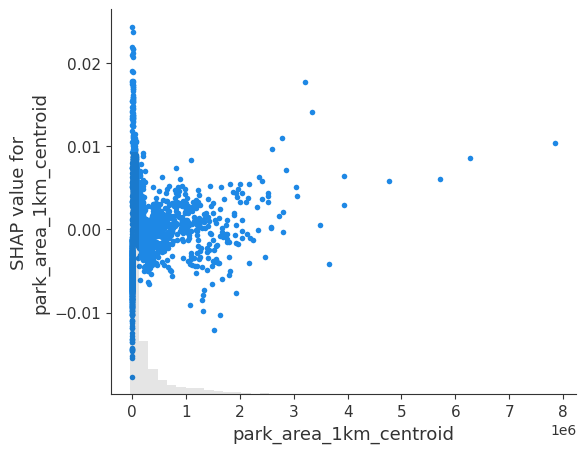

In [23]:
shap.plots.scatter(shap_values[:, "park_area_1km_centroid"])

We see a similar phenomenon with respect to park area within 500m and 1km buffers of tract centroids: at low levels of park area within buffers, there is a higher variation in model predictions. This indicates a lack of direct relationships between low park access and model predictions for economic mobility since there isn't consistency in model predictions among these kinds of tracts. It would appear the predictions are more neighborhood context-dependent. 